In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

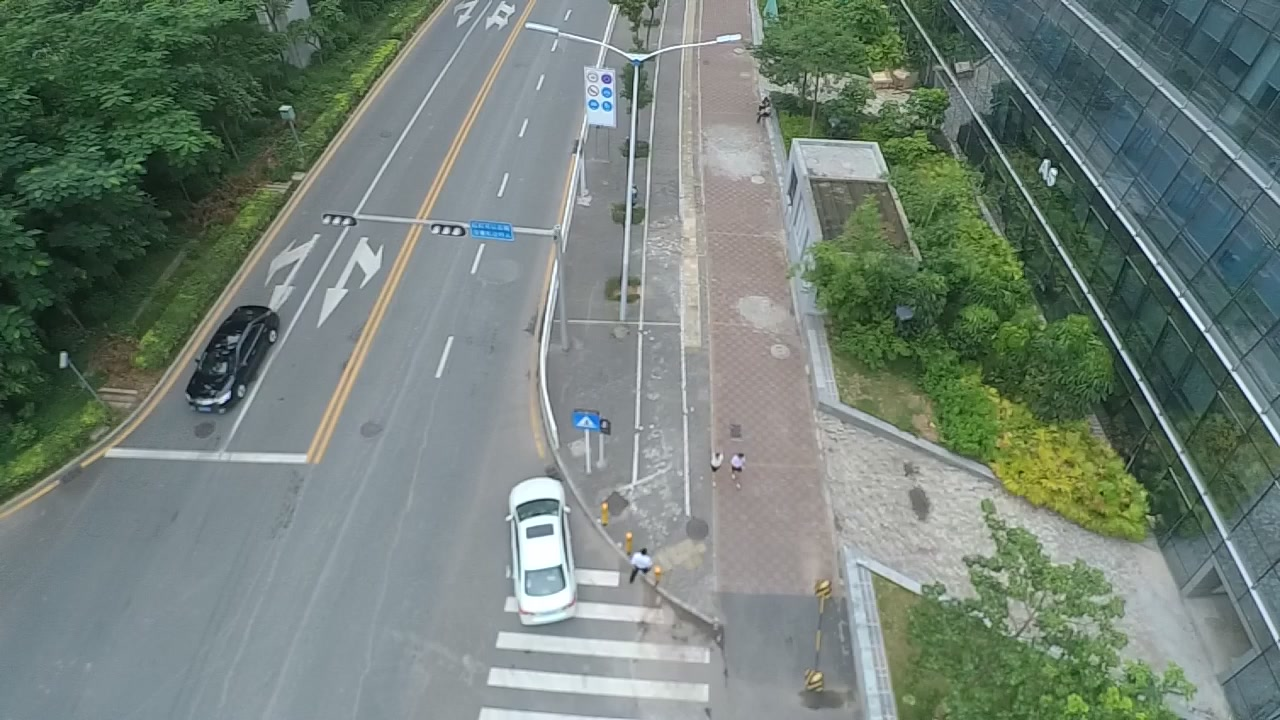

In [34]:
model_builder = keras.applications.xception.Xception
img_size = (256, 256)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_43"

# The local path to our target image
img_path = ("/kaggle/input/aerosca/aeroscapes/JPEGImages/200003_003.jpg")

display(Image(img_path))

In [35]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index=0):  
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        preds = tf.nn.softmax(preds)  # Ensure softmax is applied
        
        # Select the class-specific activation map (for segmentation, it's per pixel)
        class_channel = preds[..., class_index]  # Choose a class index (e.g., Road = 2)

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [36]:
import tensorflow as tf
from tensorflow.keras import layers as L

class ECALayer(L.Layer):
    """ Efficient Channel Attention (ECA) Layer """
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.k_size = k_size
        self.conv = L.Conv1D(1, kernel_size=k_size, padding="same", use_bias=False)
        self.sigmoid = L.Activation("sigmoid")

    def call(self, x):
        ch_avg = L.GlobalAveragePooling2D(keepdims=True)(x)  
        ch_avg = tf.squeeze(ch_avg, axis=[1, 2])  
        ch_avg = tf.expand_dims(ch_avg, axis=-1)  

        ch_avg = self.conv(ch_avg)  
        ch_avg = self.sigmoid(ch_avg)

        ch_avg = tf.reshape(ch_avg, [-1, 1, 1, x.shape[-1]]) 

        eca = x * ch_avg
        return eca 

In [37]:
def ECASCSE(x, k_size=3):
    """ECA-enhanced scSE (Efficient Channel Squeeze & Spatial Excitation + Spatial Squeeze & Efficient Channel Excitation)"""
    
    # Efficient Channel Attention (ECA replaces SE)
    eca = ECALayer(k_size)(x)

    # Spatial Attention
    spatial = L.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    sSE = L.Multiply()([x, spatial])

    # Combining both attentions
    x_out = L.Add()([eca, sSE])
    return x_out

In [16]:
# def sECA(x, k_size=3):
#     """ECA-enhanced scSE (Efficient Channel Squeeze & Spatial Excitation + Spatial Squeeze & Efficient Channel Excitation)"""
    
#     # Efficient Channel Attention (ECA replaces cSE)
#     eca = ECALayer(k_size)(x)

#     # Spatial Attention
#     spatial = L.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
#     sSE = L.Multiply()([x, spatial])

#     # Combining both attentions
#     x_out = L.Add()([eca, sSE])
#     return x_out

In [38]:
tf.keras.config.enable_unsafe_deserialization()
custom_objects = {
    # "sECA": sECA,
    "ECALayer": ECALayer,
    "ECASCSE": ECASCSE
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


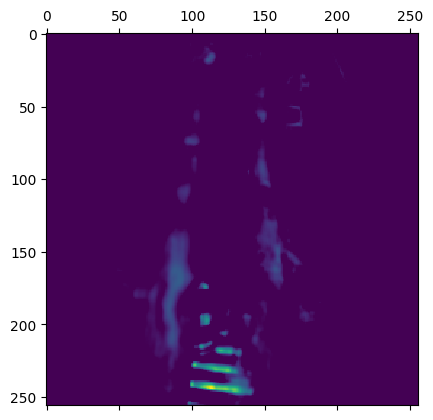

In [39]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = keras.models.load_model("/kaggle/input/aerosecase/kaggle/working/files/modified_uavid_dataset/UnetModel.keras", custom_objects = custom_objects)  # Replace with your actual model path

# Remove last layer's softmax
model.layers[-1] = keras.layers.Activation("softmax")

# Print what the top predicted class is
preds = model.predict(img_array)
# Convert to segmentation mask
pred_mask = np.argmax(preds[0], axis=-1) 

# Generate class activation heatmap
class_index = 11  # Example: Road class (change based on your dataset)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index=class_index)

# Display heatmap
# plt.imshow(pred_mask, cmap="jet")  
# plt.colorbar()
plt.matshow(heatmap)
plt.show()

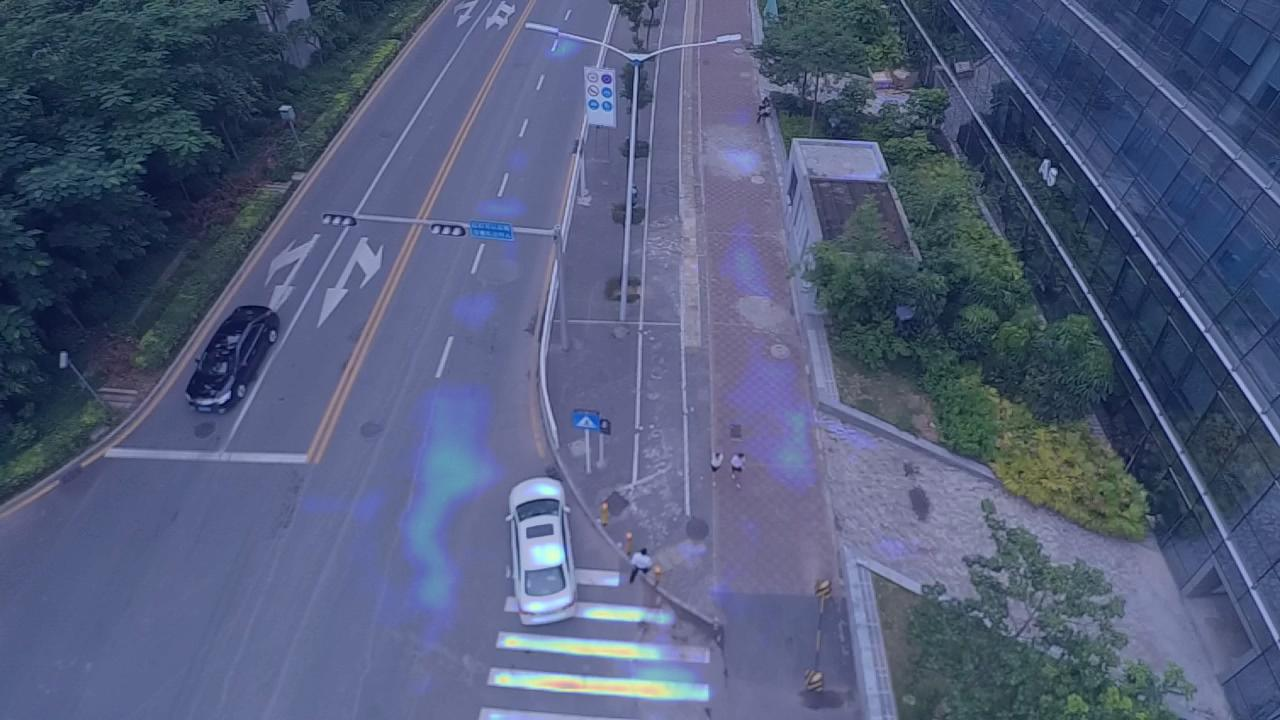

In [40]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)